Epoch [1/10], Loss: 0.2066
Epoch [2/10], Loss: 0.3372
Epoch [3/10], Loss: 0.2430
Epoch [4/10], Loss: 0.1780
Epoch [5/10], Loss: 0.0932
Epoch [6/10], Loss: 0.1038
Epoch [7/10], Loss: 0.4529
Epoch [8/10], Loss: 0.6375
Epoch [9/10], Loss: 0.0939
Epoch [10/10], Loss: 0.2495
Accuracy: 0.9276


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: fire  nofire nofire
Actual: fire  nofire nofire


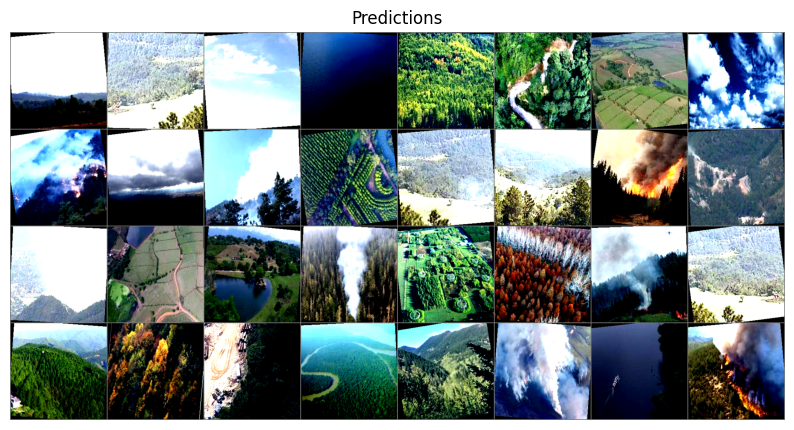

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
data_folder = './fire_dataset'
dataset = ImageFolder(root=data_folder, transform=transform)

# Splitting dataset
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Using a pre-trained ResNet model and modifying it for binary classification
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False  # Freeze all the parameters for fine-tuning

# Replace the final layer to match the number of classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # For binary classification

model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# Training the model
def train_model(num_epochs):
    model.train()
    for epoch in range(num_epochs):
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model and visualize results
def evaluate_model():
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    print(f'Accuracy: {accuracy:.4f}')

    # Display some image results
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.title('Predictions')
    images = images.cpu()
    # Convert images to grid and undo normalization for visualization
    images = make_grid(images)
    images = images / 2 + 0.5  # undo normalization
    npimg = images.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

    # Print corresponding labels
    print('Predicted:', ' '.join(f'{dataset.classes[preds[j]]:5s}' for j in range(len(images))))
    print('Actual:', ' '.join(f'{dataset.classes[labels[j]]:5s}' for j in range(len(images))))

# Run the training and evaluation
train_model(10)
evaluate_model()


Confusion Matrix:
[[314  15]
 [ 47 618]]


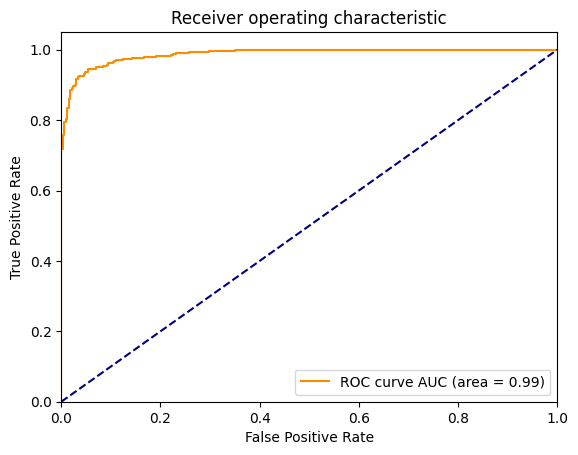

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc

def evaluate_metrics():
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)[:, 1]
            all_probs.extend(probabilities.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)

    # Calculate ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    # Plotting the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve AUC (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Call the function to print metrics and plot ROC curve
evaluate_metrics()


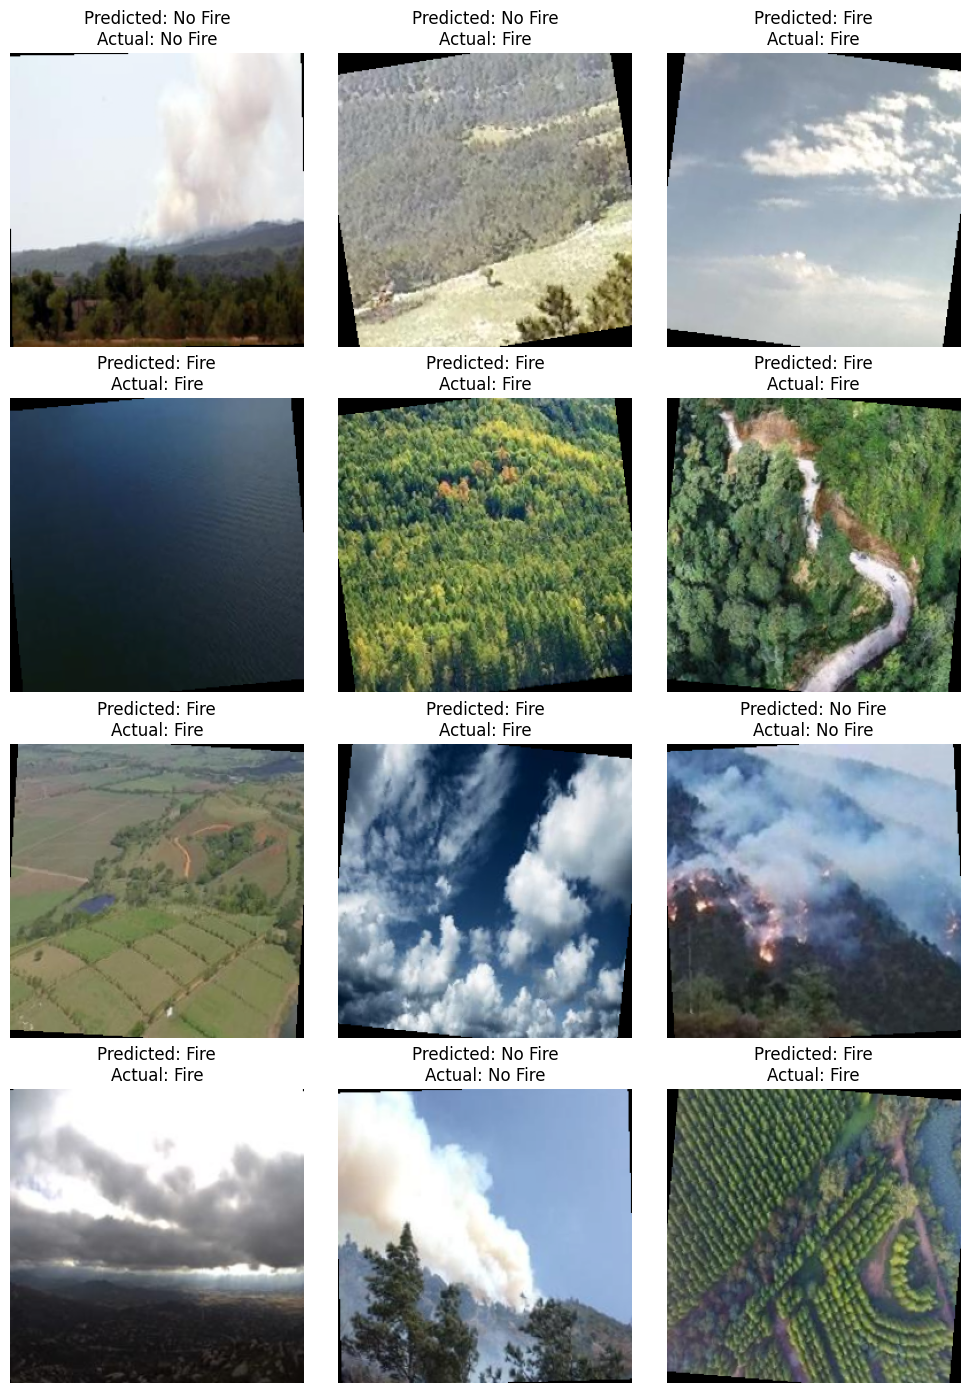

In [11]:
import torch
import matplotlib.pyplot as plt

# Assuming model and test_loader are already defined and available
# Get predictions for 12 images
model.eval()
images, labels = next(iter(test_loader))
images, labels = images.to(device)[:12], labels.to(device)[:12]
outputs = model(images)
_, preds = torch.max(outputs, 1)
images = images.cpu()

# Define inverse normalization for displaying images
inverse_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

# Plot the results in a 4x3 grid
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(10, 14))
for ax, image, pred, actual in zip(axes.flatten(), images, preds, labels):
    image = inverse_normalize(image)  # Apply inverse normalization
    ax.imshow(image.permute(1, 2, 0).numpy())
    ax.axis('off')
    ax.set_title(f'Predicted: {"Fire" if pred.item() == 1 else "No Fire"}\nActual: {"Fire" if actual.item() == 1 else "No Fire"}')

plt.tight_layout()
plt.show()


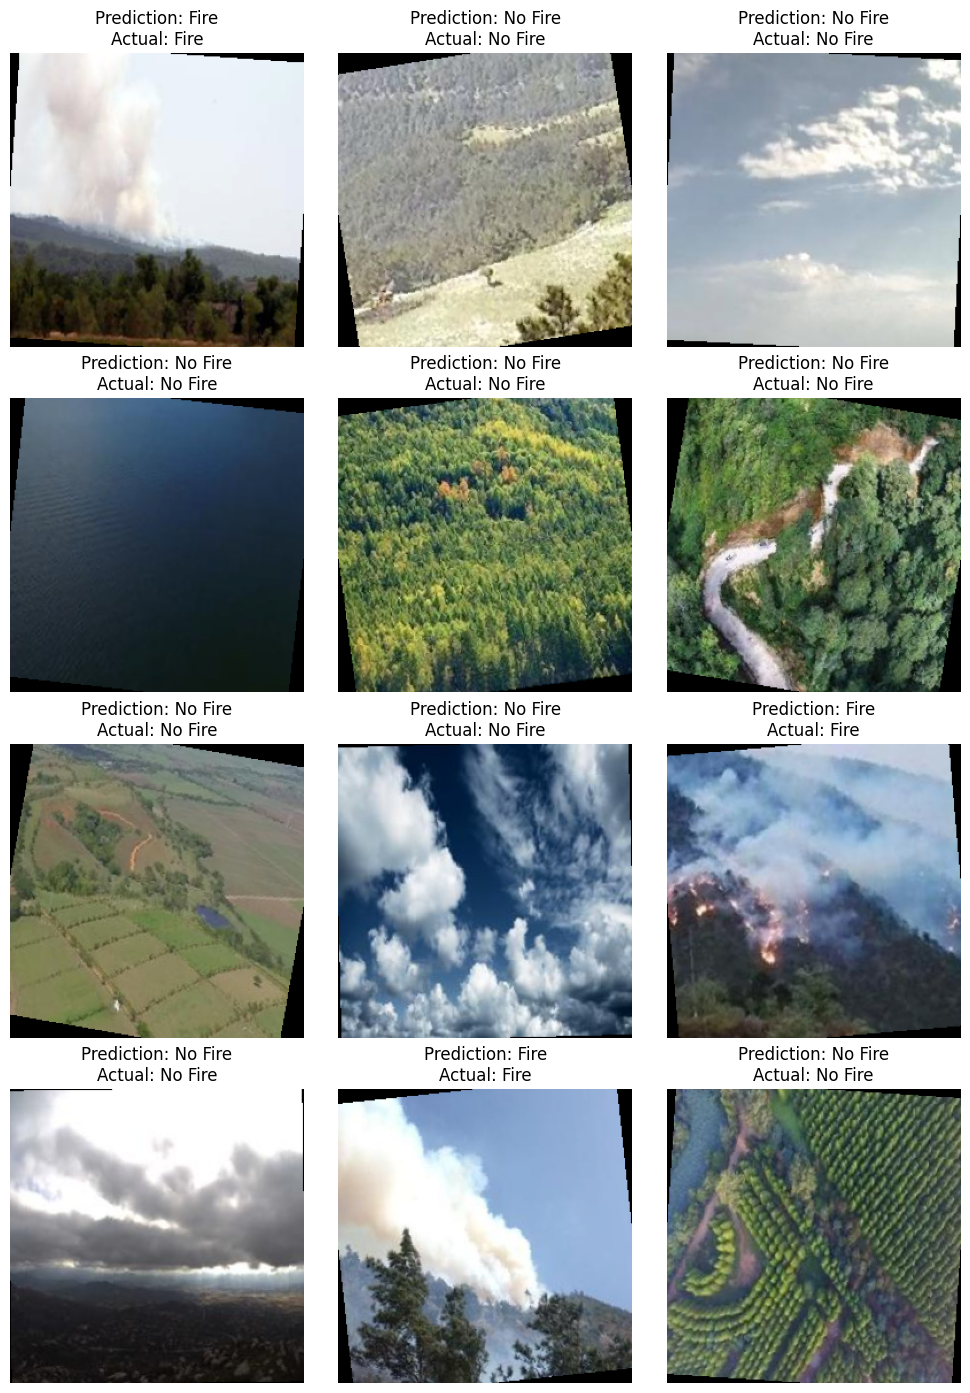